<a href="https://colab.research.google.com/github/jematos92/LearningTransformers/blob/main/Transformer_Architecture_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook I will attempt to learn about Transformer achitecture by implemnting from scratch. Following [this tutorial video](https://www.youtube.com/watch?v=QCJQG4DuHT0&list=PLTl9hO2Oobd97qfWC40gOSU8C0iu0m2l4)


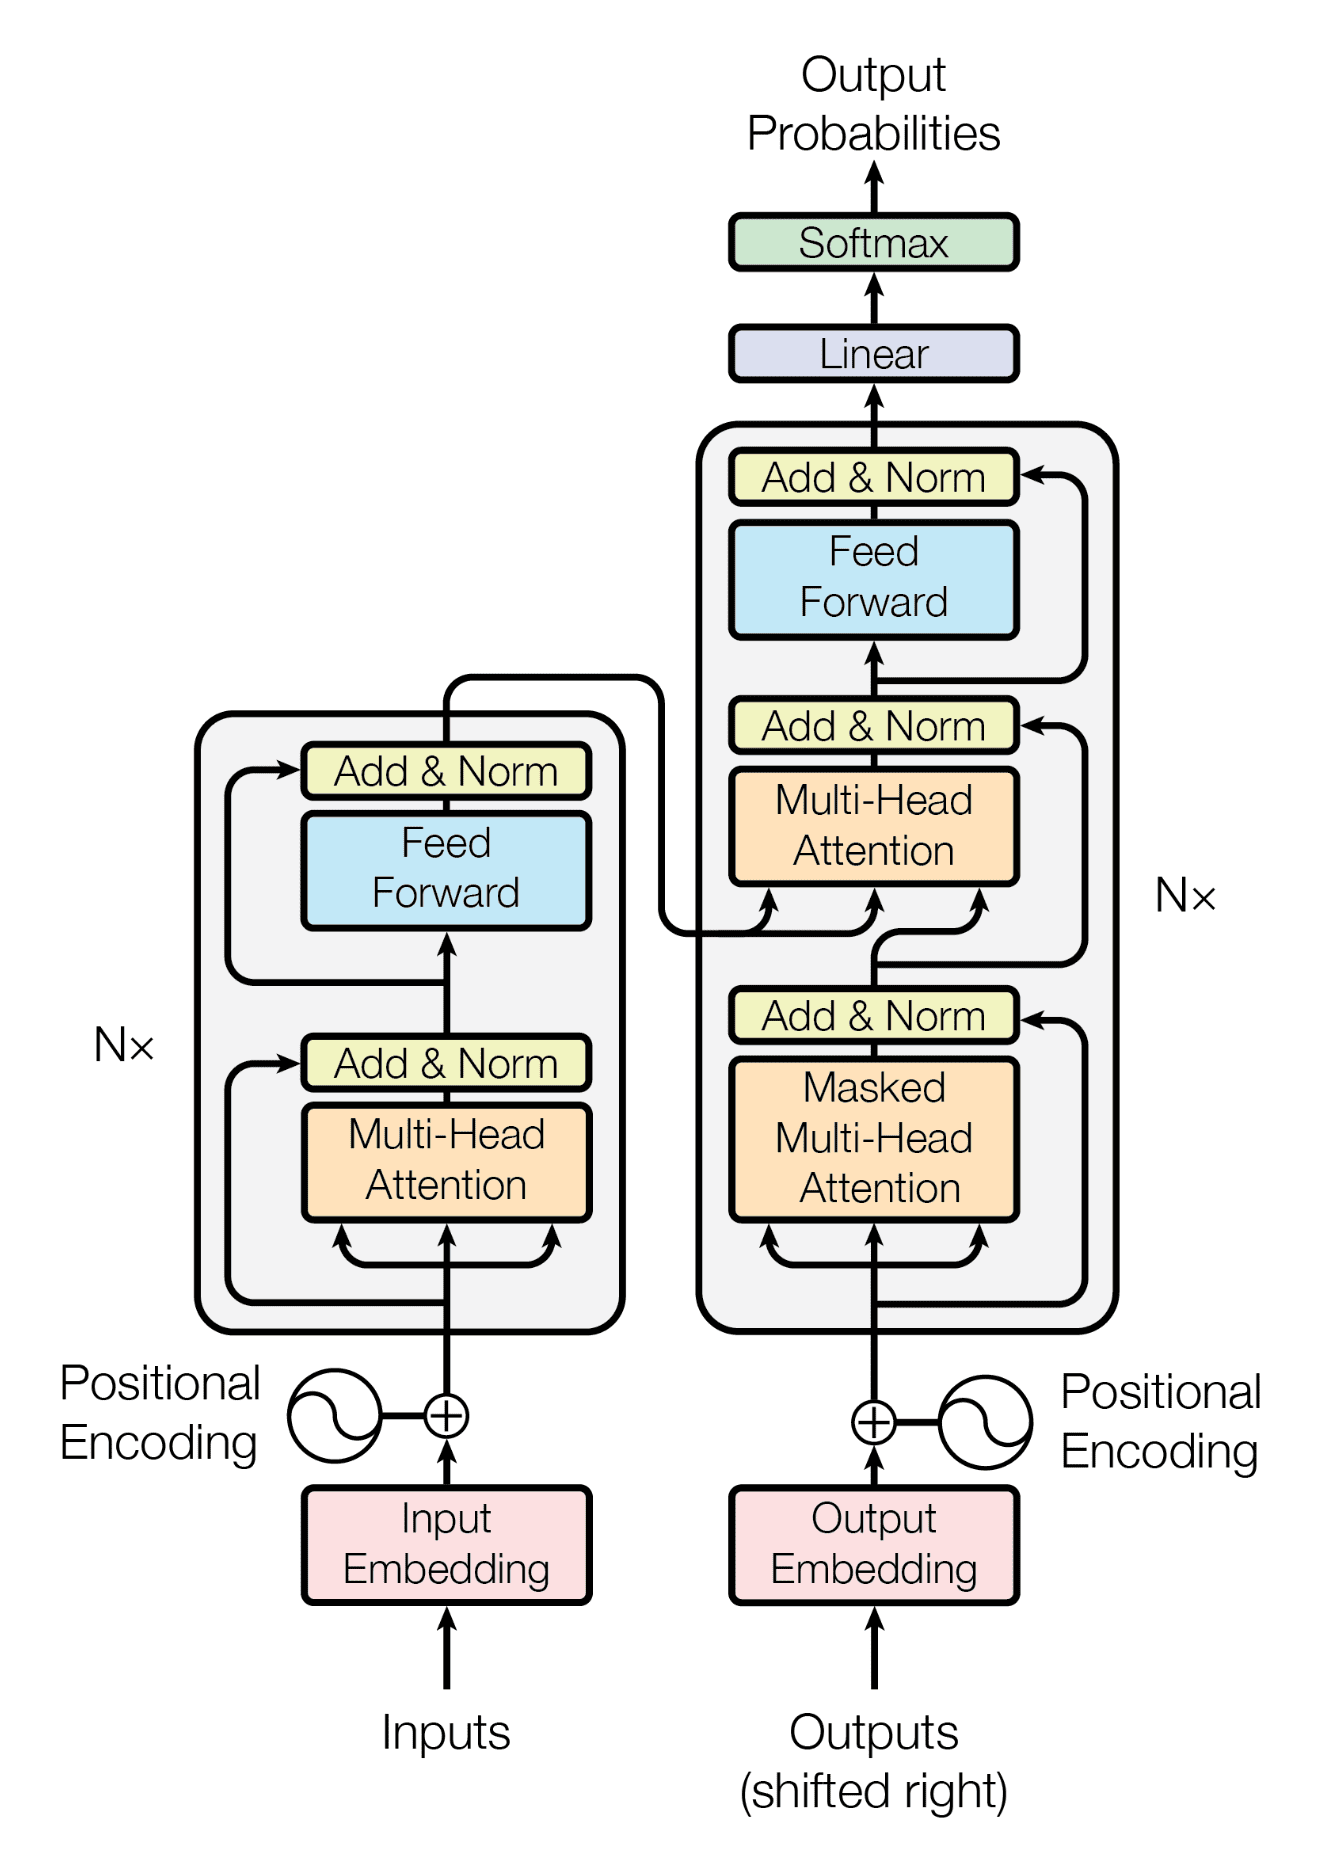



# Setup notebook

In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchtext.utils import download_from_url, extract_archive
from typing import List, Dict
from torch.utils.data import Dataset, DataLoader

import logging
logging.basicConfig(level=logging.WARNING)

In [2]:
def get_device():
  """Function that returns the right Torch device to use depending
  on whether CUDa is available or not. """
  return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = get_device()
torch.set_default_device(device)

# Programming the MultiHead attention block


## Single Head Attention

From [this video](https://www.youtube.com/watch?v=QCJQG4DuHT0&list=PLTl9hO2Oobd97qfWC40gOSU8C0iu0m2l4)

We will start by programming the masked multi-head attention in the encoder, and the Multi head attention in the decoder. They both follow the same functions. the only difference is the precense of a Mask. We will start with a single attention layer, and then stack multiple of them to get to "Multi-head" attention.

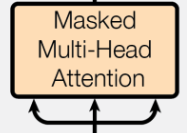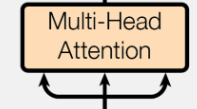

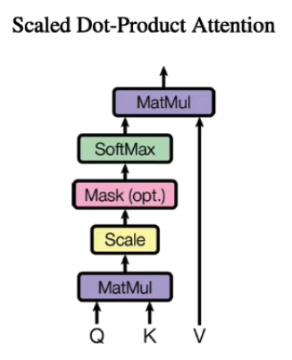

$$  \textrm{self attention} = softmax\left (\frac{Q\cdot K^{T}}{\sqrt{d_{k}}} + M \right )V $$



### Building the softmax

In [3]:
sequence = "My name is Javier"
sequence = sequence.split()

L = len(sequence) # Length of the input sequence or "Query" venctor.
d_k = 8 # Length of the Keys vector.
d_v = 8 # Length of the Values vector.

# each word will have one of each vector. We initialize them randomly.
q = np.random.randn(L,d_k) # Represents what this word is looking for
k = np.random.randn(L,d_k) # Represents what this word currently has
v = np.random.randn(L,d_v) # Represents what this word actually offers

In [4]:
print(f"First token in squence: {sequence[0]}")
print(f"Query Vector for first token in squence: {q[0]}")
print(f"Keys Vector for first token in squence: {k[0]}")
print(f"Value Vector for first token in squence: {v[0]}")

First token in squence: My
Query Vector for first token in squence: [ 0.64493696  0.72717473 -2.09645205 -1.3592887   1.18037017 -0.37458071
 -1.74120687 -0.66026327]
Keys Vector for first token in squence: [ 0.72230264 -0.17506308  0.01191408 -0.2573422  -0.47723325 -0.81659333
 -0.51240776  1.01630646]
Value Vector for first token in squence: [-0.14649526  0.44198445  0.09211693 -0.09683768 -1.76446333 -0.92189686
  0.42086467  1.06362801]


In [5]:
# By multiplying the Query Matrix by the Key Metric, whe get the attention
# Matrix which tells us how much each words focuses on other words.
# This multiplication of "What each word is looking for", which "What each word currently has"

attention_matrix = q @ k.T

In [6]:
# The square root over the size of vector d_k is a normalizing factor,
# to minimize the variance of the vectors
# The following is the variance of the Query, Key and Attention matrix before we normalize

print(f"Variance of Queries: {q.var()} \nVariance of Keys: {k.var()} \nVariance of attention matrix: {attention_matrix.var()}")

Variance of Queries: 1.045365225050074 
Variance of Keys: 1.0895169826384317 
Variance of attention matrix: 8.980041274666565


In [7]:
# Now we normalize and we notice that totice that variance for the last vector
# is now closer to the variance of original vectors.

scaled_attention_matrix = attention_matrix / math.sqrt(d_k)
print(f"Variance of Queries: {q.var()} \nVariance of Keys: {k.var()} \nVariance of attention matrix: {scaled_attention_matrix.var()}")


Variance of Queries: 1.045365225050074 
Variance of Keys: 1.0895169826384317 
Variance of attention matrix: 1.1225051593333206


### Masking

Not required for the **encoder** because all inputs are passed at the same time.

Masking is required for the output **decoder** because in reality we don't have access to information from the future words.


In [8]:
mask = np.tril(np.ones((L,L)))
mask

array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]])

We now change 0s to -Inf, and 1s to 0, because we will use this mask as an addition, and so that the softwmax function stills adds up to 1.

In [9]:
mask[mask == 0] = -np.infty
mask[mask == 1] = 0
mask

array([[  0., -inf, -inf, -inf],
       [  0.,   0., -inf, -inf],
       [  0.,   0.,   0., -inf],
       [  0.,   0.,   0.,   0.]])

In [10]:
scaled_attention_matrix + mask

array([[ 0.22171672,        -inf,        -inf,        -inf],
       [ 0.11048786, -0.11048248,        -inf,        -inf],
       [ 0.2355048 , -0.26389834, -0.87059512,        -inf],
       [ 0.65557441,  0.26081831, -1.17863257, -1.50891113]])

$$softmax = \frac{e^{x_{i}}}{\sum_{j}e_{x}^{j}}$$

In [11]:
def softmax(x):
  return(np.exp(x).T / np.sum(np.exp(x),axis =-1)).T

We now calculate the attention vector for the masked case. Notice that the attention vector doesn't incorporate any context on future elements, this will happen in the output self attention layer of the transformer architecture.

However, when we calculate the same vector without the mask, we see those values, this will apply to the input self attention layer of the transformer architecture.

In [12]:
 # With attention mask, the first words only focuses on itself.
 # This mask is required for the Decoder.
attention_matrix_decoder = softmax(scaled_attention_matrix + mask)
attention_matrix_decoder

array([[1.        , 0.        , 0.        , 0.        ],
       [0.5550189 , 0.4449811 , 0.        , 0.        ],
       [0.51606522, 0.31319626, 0.17073852, 0.        ],
       [0.51324335, 0.34584614, 0.08198556, 0.05892495]])

In [13]:
# without attention matrix, the first word also focuses on future words which is not possible
# This mask is not required for the Encoder
attention_matrix_encoder = softmax(scaled_attention_matrix)
attention_matrix_encoder

array([[0.21239957, 0.00703152, 0.18819626, 0.59237265],
       [0.24735466, 0.19831424, 0.30570842, 0.24862267],
       [0.21914811, 0.13299941, 0.07250445, 0.57534803],
       [0.51324335, 0.34584614, 0.08198556, 0.05892495]])

In [14]:
# By multipliying the attention matrix with the Value Vectos.
# Remember value vectors are "What the word actually offers"
# This result should better encapsulate the context of the word.
attention_output = attention_matrix_decoder @ v
attention_output

array([[-0.14649526,  0.44198445,  0.09211693, -0.09683768, -1.76446333,
        -0.92189686,  0.42086467,  1.06362801],
       [-0.20083333, -0.21736812, -0.10278367, -0.84227238, -0.56345199,
        -0.7528344 , -0.33899694,  0.11401207],
       [-0.17917702, -0.21974872,  0.04180466, -1.22386813, -0.67155249,
        -0.69240962, -0.15239001,  0.33593748],
       [-0.09268826, -0.07570434,  0.04964893, -0.90857616, -0.54978192,
        -0.63014242, -0.3341417 ,  0.19251164]])

In [15]:
# Notice that for the masked output from the Decoder, the vector for
# the first word is going to be the same as the value vector.
#  This is because there is no context from other words for this first word.
# As you start looking at the second, third and fourth token, the output starts
# to change into a linear combination starts to incorporate the context from previous words.
v

array([[-0.14649526,  0.44198445,  0.09211693, -0.09683768, -1.76446333,
        -0.92189686,  0.42086467,  1.06362801],
       [-0.26860846, -1.03976963, -0.34588056, -1.77204297,  0.93455315,
        -0.54196508, -1.28676203, -1.070431  ],
       [-0.11390954, -0.71565322,  0.6008885 , -3.62481972, -0.31435718,
        -0.27474332,  0.19576966,  0.71624753],
       [ 1.43802574,  1.9639156 ,  1.23424473,  0.86826096,  0.99072299,
         0.89905094, -2.05645154, -0.71117396]])

### putting it all together

Now we will calculate the full self-attention matrix, this incorporates the context of the word. We simulate now, with and without a max so you can see what happens in the self attention layer for both, the input and the output layer.

In [16]:
# this function can be reused for decoder (Masked) and decoder (Unmasked).
def self_attantion(q,k,v,mask=None):
  d_k = q.shape[-1]
  scaled = (q @ k.T)/ math.sqrt(d_k)
  if mask is not None:
      scaled += mask
  # each row adds up to one, because it is a probability distribution
  attention = softmax(scaled)
  out = attention @ v
  return out, attention,

In [17]:
# This is what happens in the input self attention.
self_attantion(q,k,v)

(array([[ 0.79740552,  1.11525278,  0.86135132, -0.20087189,  0.15951645,
          0.28124619, -1.10099896, -0.06809754],
        [ 0.23319753,  0.17261852,  0.44475041, -1.26764316, -0.10089848,
         -0.19598179, -0.60251244,  0.09296057],
        [ 0.7512774 ,  1.03661824,  0.7278727 , -0.02016578,  0.28483443,
          0.22323407, -1.24788806, -0.26651602],
        [-0.09268826, -0.07570434,  0.04964893, -0.90857616, -0.54978192,
         -0.63014242, -0.3341417 ,  0.19251164]]),
 array([[0.21239957, 0.00703152, 0.18819626, 0.59237265],
        [0.24735466, 0.19831424, 0.30570842, 0.24862267],
        [0.21914811, 0.13299941, 0.07250445, 0.57534803],
        [0.51324335, 0.34584614, 0.08198556, 0.05892495]]))

In [18]:
# This happens in the output self attention.
self_attantion(q,k,v,mask)

(array([[-0.14649526,  0.44198445,  0.09211693, -0.09683768, -1.76446333,
         -0.92189686,  0.42086467,  1.06362801],
        [-0.20083333, -0.21736812, -0.10278367, -0.84227238, -0.56345199,
         -0.7528344 , -0.33899694,  0.11401207],
        [-0.17917702, -0.21974872,  0.04180466, -1.22386813, -0.67155249,
         -0.69240962, -0.15239001,  0.33593748],
        [-0.09268826, -0.07570434,  0.04964893, -0.90857616, -0.54978192,
         -0.63014242, -0.3341417 ,  0.19251164]]),
 array([[1.        , 0.        , 0.        , 0.        ],
        [0.5550189 , 0.4449811 , 0.        , 0.        ],
        [0.51606522, 0.31319626, 0.17073852, 0.        ],
        [0.51324335, 0.34584614, 0.08198556, 0.05892495]]))

## Multi-Head Attention

From [this video](https://www.youtube.com/watch?v=HQn1QKQYXVg&list=PLTl9hO2Oobd97qfWC40gOSU8C0iu0m2l4&index=2)

Now that we have single attention head, we will stack multiple of them in order to get multi-head attention.

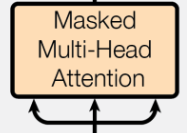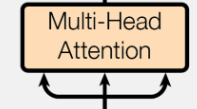

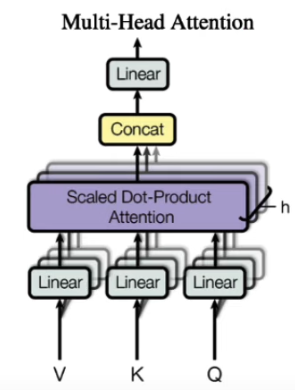

Every token has its own vector representation that is broken down into 3 component vectors, the Query, Key and Value vectors. Each of these vectors is split into separate pieces, where each piece is part of an attention head. All attention heads will generate output vectors that are concatenated to make the final word embedding.

Word = [512,1]

Q,K,V = [512,1] each

each Q,K,V is broken into 8 vectos = [64,1] each

These pieces are passed to an attention unit each. Each of the 8 attention heads generates an attention matrix. of size [squence length, sequence length].

The 8 attentions matrixes will generate 8 outputs vectors that are concatenated to make the word vector more contextually aware.



### Prepare Input

In [19]:
sequence = "My name is Javier"
sequence = sequence.split()

sequence_length = len(sequence) # Length of the input sequence or "Query" venctor.
batch_size = 1 # For parallel processing, setting to 1 for demonstration.
input_dim = 512 # Size of vector representation of every word that goes into the attention unit. Q, K, V
d_model = 512 # Size of the vector representation from the attention unit.
num_heads = 8 # Number of attention units. This also size of each piece from splitting Q, K, V


In [20]:
x = torch.rand(batch_size,sequence_length,input_dim) # Random data, words entering the attention unit.
print(x)
print(x.shape) # [Batch, Word in sequence, Vector Embedding Component]

# This is the value that is Input to the Multi-head attention phase,
# It is not the input to the transformer! it includes already the
# input embedding, and position encoding.

tensor([[[0.5033, 0.8448, 0.2412,  ..., 0.5190, 0.7013, 0.4382],
         [0.3098, 0.5732, 0.6491,  ..., 0.7873, 0.3753, 0.7943],
         [0.2266, 0.1382, 0.4775,  ..., 0.6607, 0.1210, 0.6807],
         [0.2908, 0.1657, 0.7625,  ..., 0.7832, 0.6073, 0.6953]]],
       device='cuda:0')
torch.Size([1, 4, 512])


### Prepare QKV Vectors

In [21]:
# PyTorch Linear Layer : https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#linear
# A linear layer that transforms the word empedding into Q, K, V Vectors
kqv_layer = nn.Linear(input_dim, # Input: Word Embedding Component
                      3 * d_model) # Output: Q, K, V Vectors concatenated.

# Pass the token mbeddings through the inner layer.
kqv = kqv_layer(x) #Create all the kqv vectors concatenated.
kqv.shape # [Batch, Word, QKV Concatenated value]

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'kqv distribution')

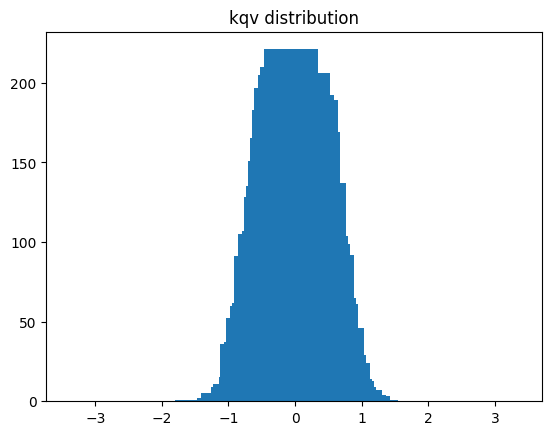

In [22]:
# Distribution if Q,K,V values is normal, because we are sampling our test data from this distribution.
# this will depend on your data in the real case.
hist_max = 3
y_val = torch.histc(kqv, bins = 200,
                    min=-hist_max, max=hist_max)
x_val = np.arange(-1,1,0.01) * hist_max
plt.bar(x_val,y_val.cpu())
plt.title("kqv distribution")


In [23]:
head_dim = d_model // num_heads
kqv = kqv.reshape(batch_size,
                  sequence_length,
                  num_heads,
                  3*head_dim)
kqv.shape #[Batch, Word or Token, Attention Head, Head Input Component]
# Head Input Component includes the components for each Q,V,K

torch.Size([1, 4, 8, 192])

In [24]:
# Reorder KQV vector so that it is easier to process parallel operations
# Word and KQV component dimensions (last 2 dimensions).
# Order is now [Batch, Attention Head, Word or Token, Head Input Component]
kqv = kqv.permute(0,2,1,3)
kqv.shape

torch.Size([1, 8, 4, 192])

In [25]:
#Split into 3 separate vectors accross the latest dimension.
q, k, v = kqv.chunk(3, dim=-1)
q.shape, k.shape, v.shape  #[Batch,  Attention Head,  Word or Token, Vector Component]

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

In [26]:
d_k = q.size()[-1]
d_k # The size of 1 attention layer.

64

In [27]:
k.size()

torch.Size([1, 8, 4, 64])

### Prepare Attention Heads

$$  \textrm{self attention} = softmax\left (\frac{Q\cdot K^{T}}{\sqrt{d_{k}}} + M \right )V $$



In [28]:
# Note that we need to trasnpose along the 'Word' and 'Head' Dimension.
scaled = torch.matmul(q, k.transpose(-2,-1)) / math.sqrt(d_k)
scaled.size() #[Batch, Attention Head, Word, Word]
# This is a probability distribution for how much a word, relates to the other
# words, along each head dimension.

torch.Size([1, 8, 4, 4])

In [29]:
mask = torch.full([L, L],float('-inf'))
mask = torch.triu(mask, diagonal=1)
print(mask.size())
print("Mask of the first head")
print(mask[0][0])

torch.Size([4, 4])
Mask of the first head
tensor(0., device='cuda:0')


In [30]:
# Masked Value for First Head
(scaled + mask)[0][0]

tensor([[ 0.0785,    -inf,    -inf,    -inf],
        [ 0.0646,  0.0335,    -inf,    -inf],
        [-0.0245, -0.0031, -0.0175,    -inf],
        [ 0.0507,  0.0172,  0.0373,  0.0121]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [31]:
#Apply softmask
attention = F.softmax(scaled + mask, dim =-1)
attention.shape #[Batch, Attention Layer, Word, Word]

torch.Size([1, 8, 4, 4])

In [32]:
#Multiply by the Values
output_values = torch.matmul(attention, v)
output_values.shape #[Batch, Attention Head, Word, Attention Embedding]
# Attention embedding now holds the context of each word


torch.Size([1, 8, 4, 64])

### Attention: Scaled Dot Product

In [33]:
def scaled_dot_product(q,k,v,mask = None):
  '''
  Function to calculate the scaled dot product of a transformer encoder or decoder.
  If this is used in a decoder you will need to pass a mask.
  '''
  logging.debug("---Running Scaled Doct Product to calculate attention---")
  logging.debug(f"k.size(): {k.size()}")
  logging.debug(f"q.size(): {q.size()}")
  logging.debug(f"v.size(): {v.size()}")
  if mask!= None: logging.debug(f"Attention Mask: {mask.size()}")
  else: logging.debug("[No Attention Mask]")
  d_k = q.size()[-1]
  scaled = torch.matmul(q,k.transpose(-1,-2)) / math.sqrt(d_k)
  # if mask is not None:
  #   print(f"Applying Mask in Scaled dot Product \n Scaled Size: {scaled.size()}\n Mask Size: {mask.size()}")
  #   scaled += mask
  logging.debug(f"Scaled Dot Product Size: {scaled.size()}")

  if mask is not None:
      logging.debug(f"Applying Atttention mask:")
      scaled = scaled.permute(1, 0, 2, 3)
      logging.debug(f"Permute Scaled Product to {scaled.size()} so that mask can be applied")
      scaled = scaled + mask
      scaled = scaled.permute(1, 0, 2, 3)
      logging.debug(f"Permute Scaled Product to apply mask :{scaled.size()}")
  attention = F.softmax(scaled, dim=-1)
  values = torch.matmul(attention,v)
  return values, attention


output_values, attention = scaled_dot_product(q,k,v)


#### Unmasked case

In [34]:
output_values, attention = scaled_dot_product(q,k,v)
print(attention[0][0]) # First Attention head without Masked Values.
print(attention.shape) # [Batch, Attention Head, Word, Word]
print(output_values.shape) # [Batch, Attention Head, Word, Attention Word Embedding]

# Concatenate all the attention word embeddings into a single word embedding
# This is the same as the original word embedding
output_values = output_values.reshape(batch_size, sequence_length, num_heads * head_dim)
print(output_values.shape) # [Batch, Word, Word Embedding]

# Pass everything through a linear layer so that the heads can communicate with
# each other the information they've learned.
linear_layer = nn.Linear(d_model,d_model)
out = linear_layer(output_values)
print(out.shape) # [Batch, Word, Word Embedding]



tensor([[0.2537, 0.2533, 0.2416, 0.2514],
        [0.2550, 0.2472, 0.2404, 0.2575],
        [0.2503, 0.2557, 0.2520, 0.2420],
        [0.2554, 0.2469, 0.2520, 0.2457]], device='cuda:0',
       grad_fn=<SelectBackward0>)
torch.Size([1, 8, 4, 4])
torch.Size([1, 8, 4, 64])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])


#### Masked Case

In [35]:
output_values, attention = scaled_dot_product(q,k,v, mask=mask)
print(attention[0][0]) # First Attention head with Masked Values.
print(f"attention: {attention.shape}") # [Batch, Attention Head, Word, Word]
print(f"output_values: {output_values.shape}") # [Batch, Attention Head, Word, Attention Word Embedding]

# Concatenate all the attention word embeddings into a single word embedding
# This is the same as the original word embedding
#output_values = output_values.reshape(batch_size, sequence_length, num_heads * head_dim)
#output_values = output_values.permute(0, 2, 1, 3).reshape(batch_size, sequence_length, num_heads * head_dim)
output_values = output_values.permute(0, 2, 1, 3)

output_values = output_values.reshape(batch_size, sequence_length, num_heads * head_dim)

print(output_values.shape) # [Batch, Word, Word Embedding]

# Pass everything through a linear layer so that the heads can communicate with
# each other the information they've learned.
linear_layer = nn.Linear(d_model,d_model)
out = linear_layer(output_values)
print(out.shape) # [Batch, Word, Word Embedding]


tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5078, 0.4922, 0.0000, 0.0000],
        [0.3302, 0.3373, 0.3325, 0.0000],
        [0.2554, 0.2469, 0.2520, 0.2457]], device='cuda:0',
       grad_fn=<SelectBackward0>)
attention: torch.Size([1, 8, 4, 4])
output_values: torch.Size([1, 8, 4, 64])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])


### Putting it all together
Lets create a class to do everything!


In [36]:
class MultiHeadAttention (nn.Module):
  def __init__(self, input_dim, d_model, num_heads):
    super().__init__()
    self.input_dim = input_dim #the dimension of the input tokens embeddings. Normally it is the same as d_model.
    self.d_model = d_model # The Dimensions of output representation of tokens.
    self.num_heads = num_heads # The number of attention heads in the model.
    self.head_dim = d_model // num_heads # The output dimension of each attention head.
    self.qkv_layer = nn.Linear(d_model, 3*d_model) # The Layer to transform word embeddings into QKV vectors.
    self.linear_layer = nn.Linear(d_model,d_model) # The output layer that connects all attention heads.

  def forward(self, x, mask=None):
    batch_size, sequence_length, input_dim = x.size() #[Batch, Word, Word Embedding]
    logging.debug(f"--- Forward Call: Multi head Attention --- ")
    logging.debug(f"Attention Layer Input size(): {x.size()}")
    if mask!= None: logging.debug(f"Attention Layer Mask size(): {mask.size()}")
    else: logging.debug("[No Mask]")

    qkv = self.qkv_layer(x)
    qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3*self.head_dim)
    qkv = qkv.permute(0,2,1,3)
    q,k,v = qkv.chunk(3,dim=-1)
    logging.debug(f"k.size(): {k.size()}")
    logging.debug(f"q.size(): {q.size()}")
    logging.debug(f"v.size(): {v.size()}")
    values, attention = scaled_dot_product(q,k,v,mask)
    logging.debug(f"Scaled Dot Product Output Size: {values.size()}")
    logging.debug(f"Attention Matrix Size: {attention.size()}")

    #values = values.reshape(batch_size,sequence_length, self.num_heads * self.head_dim)
    values = values.permute(0, 2, 1, 3).reshape(batch_size, sequence_length, self.num_heads * self.head_dim)

    out = self.linear_layer(values)
    logging.debug(f"Attention Layer Output size(): {out.size()}")
    return out




Lets test our class!

In [37]:
model = MultiHeadAttention(d_model = 512,
                           input_dim = 512,
                           num_heads = 8)
model_output = model.forward(x)

# Programming Positional Encoding

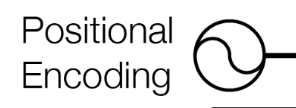



Positional encoding is a way of encoding how words are positioned inside a vector. Instead of using 1,2,3 indeces for this, transformers use periodic functions such that every component of the encoding has some periodicity that can be used to calculate attention. The encoding is as follows:

1. Pad the all the sequence of words into a max length.
2. Translate all words/tokens into one-hot encoding. Each token is translated into a vector of the size of the dictionary (**V**).
3. Pass each sequence into a feed-forward layer to map the vectors into a **d_Model** dimensional vectors. Number of parameters of this layer = Vocabulary size * d_Model. This is **X**.
4. Calculate **Positional Encoding Vectors**, and then calculate X + Positional Encoding Vectors.





$$  PE_{(pos,2i)} = \sin(pos/10000^{2i/d_{model}})  $$

$$  PE_{(pos,2i+1)} = \cos(pos/10000^{2i/d_{model}})  $$


pos = Position of the word in the sequence (1-MaxSequenceLength)

d_model = Dimension Length, we decided it is 512

i = Index of the Dimension (1-d_model)

We rewrite these functions as, just for ease of implementation

For even i:
$$  PE_{(pos,i)} = \sin(pos/10000^{i/d_{model}})  $$

For Odd i:
$$  PE_{(pos,i)} = \cos(pos/10000^{(i-1)/d_{model}})  $$

WHY? This encoding?


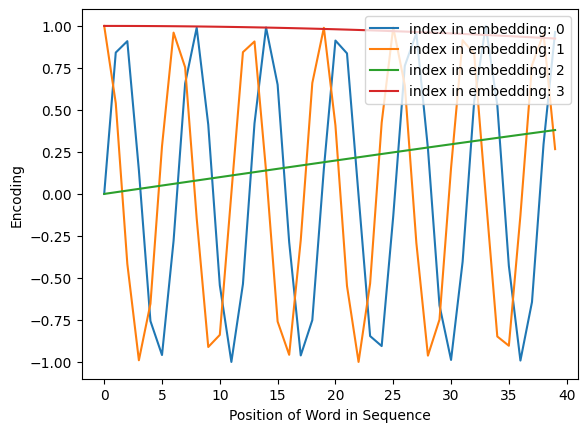

In [38]:
pos = np.arange(0,40)
d_model = 4
def is_even(number):
  if number % 2 == 0:
    return True
  else:
    return False

for i in range(0, d_model):
  if is_even(i):
    y = np.sin(pos / (10.0e3 ** (i/d_model)))
    plt.plot(pos,y, label=f"index in embedding: {i}")
  else:
    y = np.cos(pos / (10.0e3 ** ((i-1)/d_model)))
    plt.plot(pos, y, label=f"index in embedding: {i}")

plt.xlabel("Position of Word in Sequence")
plt.ylabel("Encoding")
leg = plt.legend(loc='upper right')
plt.show()



Note that:
- All values encoding values are constrained between -1 and 1.
- There is **periodicity** in the individual components of the positional encoding. When we calculate the attention matrix this will be important, for example, when a word influences another word that 3 steps ahead in the sequence, 6 steps ahead in the sequence, and 9 steps ahead, that periodicity in the positional encoding will play a major role. In reality this becomes a linear combination of these periodic functions, so long proximity and short proximity attention is possible.
- They are smooth.
- Note that the last 2 indexes are almost not required, and only the first two indeces are necessary to encode the position of a word.
- Can be used to express close proximity to long proximity.

5. For each of the resulting vectors we want to generate K, V Q vectors, all of d_model dimension. We do this by passing each vector into K, V, Q set of weights for mapping. These requires 512 x 512 learnable parameters for each of the K,Q,V mapping layers.

Then for each word, in the sequence of size Max Sequence, we have K,Q,V vectors of size 512.

These vectors could be split further to use MultiHead Attention.

In [39]:
max_sequence_length = 10 # The maximum number of tokens we can pass to the model.
d_model = 6 # Dimension of resulting embeddings. usually 512.



In [40]:
even_i = torch.arange(0,d_model, 2).float()
even_denomoninator = torch.pow(10000, even_i / d_model)
print(even_i)
print(even_denomoninator)

tensor([0., 2., 4.], device='cuda:0')
tensor([  1.0000,  21.5443, 464.1590], device='cuda:0')


In [41]:
odd_i = torch.arange(1,d_model, 2).float()
odd_denomoninator = torch.pow(10000, (odd_i-1) / d_model)
print(odd_i)
print(odd_denomoninator)

tensor([1., 3., 5.], device='cuda:0')
tensor([  1.0000,  21.5443, 464.1590], device='cuda:0')


Huh, the denominators for both, the even case, and the odd case are the same. this makes sense because we always subsctract 1 from the odd case, which will make it equal to the even case. Lets just use one denominator then.

In [42]:
denominator = even_denomoninator

In [43]:
position = torch.arange(max_sequence_length, dtype=torch.float).reshape(max_sequence_length,1)
print(position) #[Word, ..]

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]], device='cuda:0')


In [44]:
even_PE = torch.sin(position/denominator) # [Word/Token, Even Positional Encoding Idx]
odd_PE = torch.cos(position/denominator) # [Word/Token, Odd Positional Encoding Idx]

print(f"Even Positional Encoding: \n{even_PE}")
print(f"Edd Positional Encoding: \n{odd_PE}")



Even Positional Encoding: 
tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.0464,  0.0022],
        [ 0.9093,  0.0927,  0.0043],
        [ 0.1411,  0.1388,  0.0065],
        [-0.7568,  0.1846,  0.0086],
        [-0.9589,  0.2300,  0.0108],
        [-0.2794,  0.2749,  0.0129],
        [ 0.6570,  0.3192,  0.0151],
        [ 0.9894,  0.3629,  0.0172],
        [ 0.4121,  0.4057,  0.0194]], device='cuda:0')
Edd Positional Encoding: 
tensor([[ 1.0000,  1.0000,  1.0000],
        [ 0.5403,  0.9989,  1.0000],
        [-0.4161,  0.9957,  1.0000],
        [-0.9900,  0.9903,  1.0000],
        [-0.6536,  0.9828,  1.0000],
        [ 0.2837,  0.9732,  0.9999],
        [ 0.9602,  0.9615,  0.9999],
        [ 0.7539,  0.9477,  0.9999],
        [-0.1455,  0.9318,  0.9999],
        [-0.9111,  0.9140,  0.9998]], device='cuda:0')


Now we need to interieve both even and odd positions


In [45]:
stacked = torch.stack([even_PE, odd_PE], dim = 2) #Stack over a new second dimension.
print(stacked.shape)

torch.Size([10, 3, 2])


In [46]:
PE = torch.flatten(stacked, start_dim = 1, end_dim = 2) # Flatten
print(PE.shape) #[Word, Positional Encoding Embedding idx]

torch.Size([10, 6])


## Putting it all together


In [47]:
class PositionalEncoding(nn.Module):
  def __init__(self, max_sequence_length, d_model):
    super().__init__()
    self.max_sequence_length = max_sequence_length
    self.d_model = d_model

  def forward(self):
    even_i = torch.arange(0,d_model, 2).float() # [0,2,4..]
    denominator = torch.pow(10000, even_i / self.d_model)
    position = torch.arange(self.max_sequence_length, dtype=torch.float).reshape(self.max_sequence_length,1) #[Word, ..]
    even_PE = torch.sin(position/denominator) # [Word/Token, Even Positional Encoding Idx]
    odd_PE = torch.cos(position/denominator) # [Word/Token, Odd Positional Encoding Idx]
    stacked = torch.stack([even_PE, odd_PE], dim = 2) #Stack over a new second dimension.
    PE = torch.flatten(stacked, start_dim = 1, end_dim = 2) #[Word, Positional Encoding Embedding idx]
    return PE

In [48]:
PE = PositionalEncoding(max_sequence_length = 10,
                        d_model = 6)
PE.forward() #[Word, Positional Encoding Embedding Idx]

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
        [-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000],
        [-0.9589,  0.2837,  0.2300,  0.9732,  0.0108,  0.9999],
        [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
        [ 0.6570,  0.7539,  0.3192,  0.9477,  0.0151,  0.9999],
        [ 0.9894, -0.1455,  0.3629,  0.9318,  0.0172,  0.9999],
        [ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998]],
       device='cuda:0')

# Programming Normalization Layer

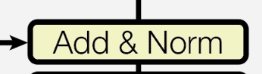

This layer takes the input before and after the multi-head attention blocks, this to ensure strong signal flow in gradient descend, and prevent vanishing gradients in deep networks. This layers just "Adds" this two signals, and then "Norm", applies **Layer Normalization.**

**Layer Normalization**: All activations in a layer, are centered around 0 and standard deviation of 1. This is, substractract the mean, and devide by standard deviation. this layer also has learnable parameters Gamma and Beta for the layer.

$$ y_{layer+} = \gamma \left( \frac{y_{layer} - \mu_{layer}}{\sigma_{layer}} \right) + β  $$


In [49]:
inputs = torch.tensor([[[0.2,0.1,0.3],[0.5,0.1,0.1]]])
BATCH, WORD, EMBEDDING = inputs.size()
inputs.size() # [Batch, Words, Empedding]

torch.Size([1, 2, 3])

In [50]:
inputs = inputs.reshape(WORD, BATCH, EMBEDDING)
inputs.size() # [Word, Batch, Empedding]

torch.Size([2, 1, 3])

We will apply layer normalization accross layer, and accross the batch!

In [51]:
 # Get the size of the dimensions we want to run normalization on
 # In this case we will run normalization over all Embeddings and Batches.
param_shape = inputs.size()[-2:]
print(f"Parameters shape: {param_shape}") #[Batch, Dimension]

# Initialize learning parameters.
gamma = nn.Parameter(torch.ones(param_shape))
betta = nn.Parameter(torch.zeros(param_shape))

Parameters shape: torch.Size([1, 3])


In [52]:
# Calculate Mean
dims = [-(i+1) for i in range(len(param_shape))]
mean = inputs.mean(dim = dims, keepdim=True)
print(f"Shape of Means: {mean.shape}")
print(f"Mean:\n {mean}")

Shape of Means: torch.Size([2, 1, 1])
Mean:
 tensor([[[0.2000]],

        [[0.2333]]], device='cuda:0')


In [53]:
# Calculate Variance
std = ((inputs - mean) ** 2).mean(dim = dims, keepdim=True)
std = (std + 1e-5).sqrt() # Add small value to prevent sqrt of zero error.
print(f"Shape of : {std.shape}")
print(f"Mean:\n {std}")

Shape of : torch.Size([2, 1, 1])
Mean:
 tensor([[[0.0817]],

        [[0.1886]]], device='cuda:0')


In [54]:
# Apply normalization:
y = ((inputs -  mean) / std)
print(f"Shape of normalized output : {y.shape}")
print(f"normalized output:\n {y}")

Shape of normalized output : torch.Size([2, 1, 3])
normalized output:
 tensor([[[-1.8236e-07, -1.2238e+00,  1.2238e+00]],

        [[ 1.4140e+00, -7.0701e-01, -7.0701e-01]]], device='cuda:0')


In [55]:
# Include learnable parameters
out = y * gamma + betta
print(f"Output: {out}")

Output: tensor([[[-1.8236e-07, -1.2238e+00,  1.2238e+00]],

        [[ 1.4140e+00, -7.0701e-01, -7.0701e-01]]], device='cuda:0',
       grad_fn=<AddBackward0>)


## Putting it all together

In [56]:
class LayerNormalization(nn.Module):
  def __init__(self, parameters_shape):
    super().__init__()
    self.parameters_shape = parameters_shape
    self.betta =  nn.Parameter(torch.zeros(parameters_shape))
    self.gamma = nn.Parameter(torch.ones(parameters_shape))

  def forward(self, input):
    dims = [-(i+1) for i in range(len(self.parameters_shape))]
    mean = input.mean(dim = dims, keepdim=True)
    std = ((input - mean) ** 2).mean(dim = dims, keepdim=True)
    std = (std + 1e-5).sqrt()
    y = ((input -  mean) / std)
    out = y * self.gamma + self.betta
    return out


In [57]:
layer_norm = LayerNormalization(parameters_shape = inputs.size()[-1:])
layer_norm.forward(inputs)

tensor([[[-1.8236e-07, -1.2238e+00,  1.2238e+00]],

        [[ 1.4140e+00, -7.0701e-01, -7.0701e-01]]], device='cuda:0',
       grad_fn=<AddBackward0>)

# Programming an Encoder


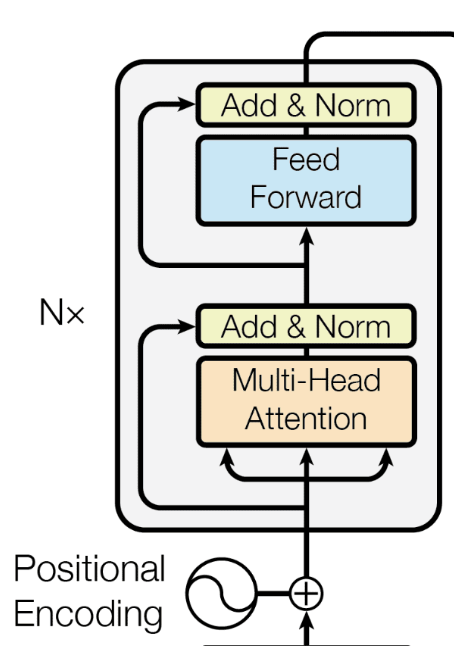

In [58]:
class PositionWiseFeedForward(nn.Module):
  def __init__(self, d_model, hidden, drop_prob = 0.1):
    super(PositionWiseFeedForward, self).__init__()
    self.linear1 = nn.Linear(d_model, hidden)
    self.linear2 = nn.Linear(hidden, d_model)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=drop_prob)

  def forward(self, x):
    x = self.linear1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.linear2(x)
    return x

In [59]:
class EncoderLayer(nn.Module):

  def __init__(self,
               d_model,
               ff_hidden,
               num_heads,
               drop_prob):
    super(EncoderLayer, self).__init__()
    self.attention = MultiHeadAttention(d_model = d_model,
                                        input_dim = d_model,
                                        num_heads = num_heads)
    self.norm1 = LayerNormalization(parameters_shape=[d_model])
    self.dropout1 = nn.Dropout(p=drop_prob)
    self.ffn = PositionWiseFeedForward(d_model = d_model,
                                        hidden = ff_hidden,
                                        drop_prob = drop_prob)
    self.norm2 = LayerNormalization(parameters_shape=[d_model])
    self.dropout2 = nn.Dropout(p=drop_prob)


  def forward(self,x, mask=None):
    logging.debug(f"--- Forward Call: Encoder --- ")
    residual_x = x
    x = self.attention(x, mask)
    x = self.dropout1(x)
    x = self.norm1(x + residual_x)
    residual_x = x
    x = self.ffn(x)
    x = self.dropout2(x)
    x = self.norm2(x + residual_x)
    return x


In [60]:
# This class is required because we cannot use Sequential.
# We cannot use Sequential becase we need to pass more than 1 parameter
# to all the layers.
class SequentialEncoder(nn.Sequential):

  # *comma separated values.
  def forward(self, *inputs):
    x,mask = inputs
    for module in self._modules.values():
      x = module.forward(x,mask)
    return x

class Encoder(nn.Module):
  def __init__(self,
               d_model,
               ff_hidden,
               num_heads,
               drop_prob,
               num_layers):
    super().__init__()

    # Create a sequential network with N Encoder Transformer layers.
    # "Nx" in diagram
    # * will upack the elements of the list as coma separated values
    self.layers = SequentialEncoder(*[EncoderLayer(d_model,
                                               ff_hidden,
                                               num_heads,
                                               drop_prob )
                                               for _ in range(num_layers)])

  ## Override forward method.
  def forward(self,x,mask=None):
    x = self.layers(x,mask)
    return x



In [61]:
# Variables.
batch_size = 30 # Number of batches for training.
max_sequence_length = 12 # Number of tokends we can pass to the Encoder.
d_model = 512 # Size of all the vector embeddings in the Encoder, Q, K, V vectors.
num_heads = 8
ffn_hidden = 2048
num_trans_layers = 5 # Number of Transformer Layers.
drop_prob = 0.1 # Probability for dropout layers.


# Input
input = torch.rand((batch_size,max_sequence_length,d_model)).float()
input.shape

torch.Size([30, 12, 512])

In [62]:
encoder = Encoder(d_model = d_model,
          ff_hidden= ffn_hidden,
          num_heads = num_heads,
          drop_prob = drop_prob,
          num_layers = num_trans_layers)

output = encoder.forward(input)
output.shape

torch.Size([30, 12, 512])

# Programming Decoder

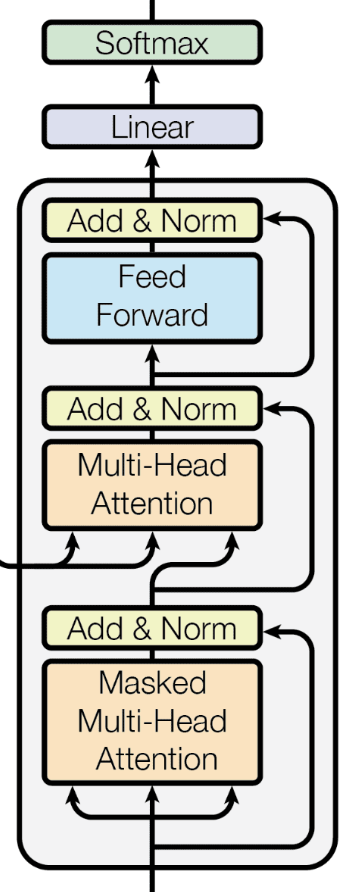

In [63]:
class CrossMultiHeadAttention (nn.Module):
  def __init__(self, input_dim, d_model, num_heads):
    super().__init__()
    self.input_dim = input_dim #the dimension of the input tokens embeddings. Normally it is the same as d_model.
    self.d_model = d_model # The Dimensions of output representation of tokens.
    self.num_heads = num_heads # The number of attention heads in the model.
    self.head_dim = d_model // num_heads # The output dimension of each attention head.
    self.kv_layer = nn.Linear(d_model, 2*d_model) # The Layer to transform word embeddings into QKV vectors.
    self.q_layer = nn.Linear(d_model, d_model) # The Layer to transform word embeddings into QKV vectors.

    self.linear_layer = nn.Linear(d_model,d_model) # The output layer that connects all attention heads.

  def forward(self, x, y, mask=None):
    batch_size, sequence_length, input_dim = x.size() #[Batch, Word, Word Embedding]
    logging.debug(f"--- Forward Call Cross Multi head Attention --- ")
    logging.debug(f"Decoder Input size(): {x.size()}")
    logging.debug(f"Encoder Output size(): {y.size()}")
    if mask!= None: logging.debug(f"Decoder Attention Mask size(): {mask.size()}")
    else: logging.debug("[No Decoder Attention Mask]")

    # Get KQV Embeddings.
    kv = self.kv_layer(x)
    q = self.q_layer(y)

    # Reshape Embeddings.
    kv = kv.reshape(batch_size, sequence_length, self.num_heads, 2*self.head_dim)
    q = q.reshape(batch_size, sequence_length, self.num_heads, self.head_dim)

    kv = kv.permute(0,2,1,3)
    q = q.permute(0,2,1,3)
    k, v = kv.chunk(2,dim=-1)
    logging.debug("---"*25)
    logging.debug(f"k.size(): {k.size()}")
    logging.debug(f"q.size(): {q.size()}")
    logging.debug(f"v.size(): {v.size()}")
    logging.debug("---"*25)
    values, attention = scaled_dot_product(q,k,v,mask)
    logging.debug(f"Scaled Dot Product size: {values.size()}")
    logging.debug(f"Attention Matrix Size: {attention.size()}")

    # values = values.reshape(batch_size,sequence_length, self.num_heads * self.head_dim)
    values = values.permute(0, 2, 1, 3).reshape(batch_size, sequence_length, d_model)

    out = self.linear_layer(values)
    logging.debug("---"*25)
    logging.debug(f"Output size: {out.size()}")
    return out


In [64]:
class DecoderLayer(nn.Module):

  def __init__(self,
               d_model,
               ff_hidden,
               num_heads,
               drop_prob):
    super(DecoderLayer, self).__init__()

    # Multihead Attention Block
    self.attention = MultiHeadAttention(d_model = d_model,
                                        input_dim = d_model,
                                        num_heads = num_heads)
    self.norm1 = LayerNormalization(parameters_shape=[d_model])
    self.dropout1 = nn.Dropout(p=drop_prob)

    #Multihead Cross Attention Block.
    self.crossattention = CrossMultiHeadAttention(d_model = d_model,
                                        input_dim = d_model,
                                        num_heads = num_heads)
    self.norm2 = LayerNormalization(parameters_shape=[d_model])
    self.dropout2 = nn.Dropout(p=drop_prob)

    # Feed Forward Block.
    self.ffn = PositionWiseFeedForward(d_model = d_model,
                                        hidden = ff_hidden,
                                        drop_prob = drop_prob)
    self.norm3 = LayerNormalization(parameters_shape=[d_model])
    self.dropout3 = nn.Dropout(p=drop_prob)



  def forward(self,x,y,mask1=None, mask2=None):
    logging.debug(f"--- Forward Call: Decoder --- ")
    logging.debug(f"Decoder Input size(): {x.size()}")
    logging.debug(f"Encoder Output size(): {y.size()}")
    if mask1!= None: logging.debug(f"Decoder Attention Mask size(): {mask1.size()}")
    else: logging.debug("[No Decoder Attention Mask]")
    if mask2!= None: logging.debug(f"Decoder Cross Attention Mask size(): {mask2.size()}")
    else: logging.debug("[No Decoder Attention Mask]")
    # Attention Block with Mask.
    residual_y = y
    y = self.attention(y, mask = mask1)
    y = self.dropout1(y)
    y = self.norm1(y + residual_y)

    # Cross Attention Block.
    residual_y = y
    y = self.crossattention(x,y,mask=mask2)
    y = self.dropout2(y)
    y = self.norm2(y + residual_y)

    # Feed Forward Block
    y = self.ffn(y)
    y = self.dropout2(y)
    y = self.norm2(y + residual_y)

    return y

# This class is required because we cannot use Sequential.
# We cannot use Sequential becase we need to pass more than 1 parameter
# to all the layers.
class SequentialDecoder(nn.Sequential):

  # *comma separated values.
  def forward(self, *inputs):
    x,y,mask1, mask2 = inputs
    for module in self._modules.values():
      y = module.forward(x,y,mask1, mask2)
    return y



class Decoder(nn.Module):
  def __init__(self,
               d_model,
               ff_hidden,
               num_heads,
               drop_prob,
               num_layers):
    super().__init__()

    # Create a sequential network with N Encoder Transformer layers.
    # "Nx" in diagram
    # * will upack the elements of the list as coma separated values
    self.layers = SequentialDecoder(*[DecoderLayer(d_model,
                                               ff_hidden,
                                               num_heads,
                                               drop_prob )
                                               for _ in range(num_layers)])

  ## Override forward method.
  def forward(self,x, y, mask1=None, mask2=None):
    y = self.layers(x,y,mask1, mask2)
    return y



In [65]:
# Variables.
batch_size = 30 # Number of batches for training.
max_sequence_length = 200 # Number of tokends we can pass to the Encoder.
d_model = 512 # Size of all the vector embeddings in the Encoder, Q, K, V vectors.
num_heads = 8
ffn_hidden = 2048
num_trans_layers = 5 # Number of Transformer Layers.
drop_prob = 0.1 # Probability for dropout layers.

In [66]:

# x: The output from the decoder. This could be the embeddings of a language.
# For translation this is the source language.
x = torch.rand((batch_size,max_sequence_length,d_model)).float()

# y: The input to the encoder.
# For translation this is the target language.
y = torch.rand((batch_size,max_sequence_length,d_model)).float()

# Create [max_sequence_length, max_sequence_length] filled with "-inf"
mask = torch.full([max_sequence_length, max_sequence_length],float('-inf'))
mask = torch.triu(mask,diagonal = 1)
print(f"mask: \n{mask}")

mask: 
tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')


In [67]:
decoder = Decoder(d_model = d_model,
          ff_hidden= ffn_hidden,
          num_heads = num_heads,
          drop_prob = drop_prob,
          num_layers = num_trans_layers)

output = decoder.forward(x,y, mask)
output.shape

torch.Size([30, 200, 512])

# Programming Text Embeddings

https://www.tensorflow.org/text/tutorials/nmt_with_attention

[Other Colab For Reference](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/nlp/ipynb/neural_machine_translation_with_transformer.ipynb#scrollTo=V5KPXqLh-7eW)

## Vocabularies

In [68]:
START_TOKEN = "[start]"
END_TOKEN = "[end]"
PADDING_TOKEN = "[pad]"

english_vocabulary = [START_TOKEN, ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                        ':', '<', '=', '>', '?', '@',
                        'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
                        'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
                        'Y', 'Z',
                        '[', '\\', ']', '^', '_', '`',
                        'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                        'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
                        'y', 'z',
                        '{', '|', '}', '~', PADDING_TOKEN, END_TOKEN]

spanish_vocabulary = [START_TOKEN, ' ', '!','¡', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                        ':', '<', '=', '>','¿', '?', '@',
                        # Capital Letters
                        'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
                        'M', 'N', 'Ñ', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
                        'Y', 'Z',
                        '[', '\\', ']', '^', '_', '`',
                        # Lower Case letters.
                        'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                        'm', 'n','ñ', 'o', 'p', 'q', 'r', 's', 't', 'u', 'ü', 'v', 'w', 'x',
                        'y', 'z',
                        # Letters with Accent
                        'á', 'é', 'í', 'ó', 'ú',
                        'Á','É','Í','Ó', 'Ú',
                        '{', '|', '}', '~', PADDING_TOKEN, END_TOKEN]


In [69]:
# Create dictionaries so that we can map each token to a number.
# The number will be simply the position in the vocabulary.
index_to_spanish = {k:v for k,v in enumerate(spanish_vocabulary)}
spanish_to_index = {v:k for k,v in enumerate(spanish_vocabulary)}
index_to_english = {k:v for k,v in enumerate(english_vocabulary)}
english_to_index = {v:k for k,v in enumerate(english_vocabulary)}

## Download Data

In [70]:
TAB = "\t"
NEW_LINE = "\n"

def download_data():
  # We will download the file from this source.
  file_name = "spa-eng.zip"
  url = f'http://storage.googleapis.com/download.tensorflow.org/data/{file_name}'

  # Download the file
  zip_file_location = f'./data_zip/{file_name}'
  download_from_url(url, zip_file_location)

  # Extract the zip file.
  extracted_location = f'./data_extracted/{file_name}'
  files = extract_archive(zip_file_location, extracted_location)

  # The file location is store in the second element of the array.
  return files[1]

def process_file(text_file):
  with open(text_file) as f:
      lines = f.read().split(NEW_LINE)[:-1]

  # Store the lines in the file in this List of Tuples structure.
  english = []
  spanish = []
  for line in lines:
      #Obtain the original english and spanish arrays from each line.
      eng, spa = line.split(TAB)

      # Add Start and End Tokens to the spanish version.
      #spa = f"{START_TOKEN} {spa} {END_TOKEN}"

      # Add Tuple to our.
      english.append(eng)
      spanish.append(spa)

  return english, spanish

In [71]:
file_path = download_data()

100%|██████████| 2.64M/2.64M [00:00<00:00, 5.53MB/s]


In [72]:
en, es = process_file(file_path)
print(f"Number of samples in dataset = {len(en)}")

Number of samples in dataset = 118964


## Visualizing sentence length

In [73]:
max_en_lenght = max(len(x) for x in en)
max_es_length = max(len(x) for x in es)
print(f"Max Sentence Length in English: {max_en_lenght}")
print(f"Max Sentence Length in Spanish: {max_es_length}")

Max Sentence Length in English: 247
Max Sentence Length in Spanish: 278


In [74]:
def inspect_length_distribution(data:List[str], language:str)->None:
  """ Plots a histogram of the lengths of sentences in the data

  Args:
    data: A List of sentences.
    language: A string to append in the chart title.

  """
  lenghts = [len(x) for x in data]
  max_lenght = max(lenghts)
  lenghts_tensor = torch.tensor(lenghts).float()
  y_val = torch.histc(lenghts_tensor, bins = max_lenght)
  x_val = np.arange(0,max_lenght)
  plt.bar(x_val,y_val.cpu())
  plt.title(f"Distribution of sentence lengths in {language}")



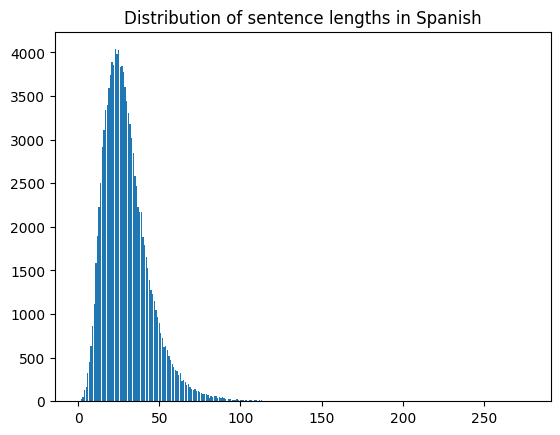

In [75]:
inspect_length_distribution(es, "Spanish")

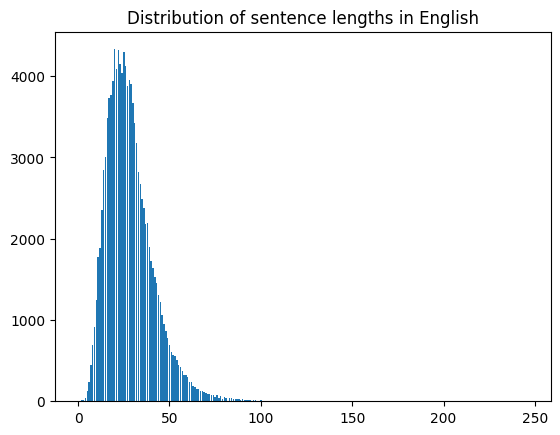

In [76]:
inspect_length_distribution(en, "English")

We can visually see that even though the max sentence length for both languages, most of the distribution is < 150. We can set this threshold manually, or we can set it using a heuristics. Say, we we wanted to capture 99% of the volume:


In [77]:
PERCENTILE = 99
es_percentile = np.percentile([len(x) for x in es], PERCENTILE)
en_percentile = np.percentile([len(x) for x in en], PERCENTILE)
print( f"{PERCENTILE}th percentile length English: {es_percentile}" )
print( f"{PERCENTILE}th percentile length Spanish: {en_percentile}" )

max_sequence_length = int(max(es_percentile, en_percentile))
print(f"Max sequence length is chosen as: {max_sequence_length}")

99th percentile length English: 80.0
99th percentile length Spanish: 74.0
Max sequence length is chosen as: 80


In [78]:
def is_valid_tokens(sentence:str,
                    vocab:List[str])-> bool:
    """checks if a sentence contains only valids token from vocabulary.

    Args:
      sentence: The sentence to check.
      vocab: The vocabulary to check the sentence against.

    Returns:
      True if the sentence contains only tokens from the vocabulary.
      False otherwise.
    """
    # Iterate through all characters of the sentence
    # Set splits the sentence in characters.
    for token in list(set(sentence)):
        # Return early is we find a token that is not in the vocabulary.
        if token not in vocab:
            return False
    return True

def is_valid_length(sentence:str, max_sequence_length:int)->int:
    """Checks if the sentence has a valid length
    Args:
      sentence: Sentence to check
      max_sequence_length: max number of characters allowed in the sentence
    """
    return len(list(sentence)) < (max_sequence_length - 1) # need to re-add the end token so leaving 1 space

def sanitize_dataset(en:List[str], es:List[str]):
  """ Checks the english and the spanish list of sentences and filters out
  the sentences that are not valid.
  Args:
    en: List of english sentences
    es: List of spanish sentences
  Returns:
    List of sanitized sentences for english and spanish.
  """
  valid_sentence_indicies = []
  invalid_sentence_indicies = []
  for index in range(len(en)):
      spanish_sentence, english_sentence = es[index], en[index]
      # Check the length of the sentences
      if is_valid_length(spanish_sentence, max_sequence_length) \
        and is_valid_length(english_sentence, max_sequence_length) \
        and is_valid_tokens(spanish_sentence, spanish_vocabulary) \
        and is_valid_tokens(english_sentence, english_vocabulary):
          valid_sentence_indicies.append(index)
      else:
          invalid_sentence_indicies.append(index)


  print(f"Number of sentences: {len(es)}")
  print(f"Number of valid sentences: {len(valid_sentence_indicies)}")

  en = [en[i] for i in valid_sentence_indicies]
  es = [es[i] for i in valid_sentence_indicies]

  return en, es

In [79]:
en, es = sanitize_dataset(en, es)

Number of sentences: 118964
Number of valid sentences: 117389


## Visualizing data

In [80]:
# Last english sentence:
en[-1]

'You say you want to go to Boston? Why in the world would you want to go there?'

In [81]:
# Last spanish sentence:
es[-1]

'¿Dices que quieres ir a Boston? ¿Por qué demonios querrías ir allí?'

## Create Torch Dataset and Data Loader

In [82]:
class TextDataset(Dataset):
  """Torch Dataset class that holds our dataset of english and spanish pairs.
  """

  def __init__(self, english_sentences:List[str], spanish_sentences:List[str]):
      self.english_sentences = english_sentences
      self.spanish_sentences = spanish_sentences

  def __len__(self):
      return len(self.english_sentences)

  def __getitem__(self, idx:int):
      return self.english_sentences[idx], self.spanish_sentences[idx]

In [83]:
# Create the Torch Dataset
dataset = TextDataset(en, es)
len(dataset)


117389

In [84]:
# Inspectes the first element of the dataset
dataset[1]


('Go.', 'Vete.')

In [85]:
# Create a data loader so that we can iterate through our Dataset
batch_size = 3
train_loader = DataLoader(dataset, batch_size)
iterator = iter(train_loader)

# Lets print the first 3 batches.
for batch_num, batch in enumerate(iterator):
    print(batch)
    if batch_num > 3:
        break

[('Go.', 'Go.', 'Go.'), ('Ve.', 'Vete.', 'Vaya.')]
[('Go.', 'Hi.', 'Run!'), ('Váyase.', 'Hola.', '¡Corre!')]
[('Run.', 'Who?', 'Fire!'), ('Corred.', '¿Quién?', '¡Fuego!')]
[('Fire!', 'Fire!', 'Help!'), ('¡Incendio!', '¡Disparad!', '¡Ayuda!')]
[('Help!', 'Help!', 'Jump!'), ('¡Socorro! ¡Auxilio!', '¡Auxilio!', '¡Salta!')]


## Tokenization

In [86]:
def tokenize(sentence:str,
             language_to_index:Dict[str, int],
             start_token=True, end_token=True):
  """Takes a sentence, and converts it into a numerical representation
  that can be passed to the transformer.
  Also appends start and end tokends if required

  Args:
    sentence: The sentence to tokenize.
    language_to_index: A dictionary where keys are the tokens, and the values are the numerical value
    start_token: Boolean, True if you want to append a start token at the begining of the tokenize sentence.
    end_token: Boolean, True if you want to append an end token at the end of the tokenized sentence

  Returns:
    Torch tensor with the tonized sentence
  """

  sentence_word_indicies = [language_to_index[token] for token in list(sentence)]
  # Add Start token if neccesary
  if start_token:
      sentence_word_indicies.insert(0, language_to_index[START_TOKEN])
  # Add End token if neccesary
  if end_token:
      sentence_word_indicies.append(language_to_index[END_TOKEN])
  # Padd the rest with the Padding token
  for _ in range(len(sentence_word_indicies), max_sequence_length):
      sentence_word_indicies.append(language_to_index[PADDING_TOKEN])
  return torch.tensor(sentence_word_indicies)

In [87]:
BATCH_ENG_IDX = 0
BATCH_ESP_IDX = 1

batch[BATCH_ENG_IDX]

('Help!', 'Help!', 'Jump!')

In [88]:
# Lists to hold the tokenized sentences
eng_tokenized, es_tokenized = [], []

# For all sentences in the batch.
for sentence_num in range(batch_size):

    # Extract the sentence from batch.
    eng_sentence, es_sentence = batch[BATCH_ENG_IDX][sentence_num], batch[BATCH_ESP_IDX][sentence_num]

    # Tokenize the english sentences without start and end tokens.
    eng_tokenized.append( tokenize(eng_sentence, english_to_index, start_token=False, end_token=False) )

    #Tokenize the Spanish words, and add start and end tokens.
    es_tokenized.append( tokenize(es_sentence, spanish_to_index, start_token=True, end_token=True) )

# Create a torch tensor for each language.
eng_tokenized = torch.stack(eng_tokenized)
es_tokenized = torch.stack(es_tokenized)


In [89]:
es_tokenized

tensor([[  0,   3,  54,  83,  70,  83,  86,  86,  83,   2,   1,   3,  35,  89,
          93,  76,  79,  76,  83,   2, 111, 110, 110, 110, 110, 110, 110, 110,
         110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110,
         110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110,
         110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110,
         110, 110, 110, 110, 110, 110, 110, 110, 110, 110],
        [  0,   3,  35,  89,  93,  76,  79,  76,  83,   2, 111, 110, 110, 110,
         110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110,
         110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110,
         110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110,
         110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110,
         110, 110, 110, 110, 110, 110, 110, 110, 110, 110],
        [  0,   3,  54,  68,  79,  88,  68,   2, 111, 110, 110, 110, 110, 110,
         11

## Create Masks for multihead attention


In [90]:
NEG_INFTY = -1e9 # Used to simulate negative infinity in the network.
# We dont use infinity, because if we find 0 rows during the softmax, the output
# is 0 by 0, leading to NANs, and numerical inestability, no learning!
# the network will get stuck!

def create_masks(eng_batch, es_batch, max_sequence_length):
  """Creates all the masks for the transformer architecture based on the batches of untokenized batch.
    Args:
      eng_batch: A batch of english sentences, untokenized
      es_batch: A batch of spanish sentences, untokenized
      max_sequence_length: The maximum number of tokens per sentence.
    Returns:
      encoder_self_attention_mask: Mask for the encoder self attention layer.
      this mask is used so that the encoder ignores padding tokens during training.

      decoder_self_attention_mask: Mask for the decoder self attention layer.
      this mask is used so that the decoder doesn't calculate attention of future tokens.
      This is cheating, since the decoder will be predicting the next token.

      decoder_cross_attention_mask: Mask for the decoder cross attention layer.
      this is the layer that connects encoder and decoder, and is also a padding mask
      to ignore the padding tokens during training.
  """

  # Get the total number of sentences in the batch.
  num_sentences = len(eng_batch)
  batch_mask_size = [num_sentences, max_sequence_length, max_sequence_length]

  # Create a look ahead mask that can be used to mask attention of future words.
  # this mask is of size [max sequence length, max sequence length]
  # First, we fill it with True.
  look_ahead_mask = torch.full([max_sequence_length, max_sequence_length] , True)
  # All the elements of the mask in and below the diagonal are set to False.
  # The resulting mas is:
  # [False, True,  True]
  # [False, False, True]
  # [False, False, False]
  look_ahead_mask = torch.triu(look_ahead_mask, diagonal=1)

  # Initialize the 3 masks. All the same size, and all full of "False"
  encoder_padding_mask = torch.full(batch_mask_size , False)
  decoder_padding_mask_self_attention = torch.full(batch_mask_size , False)
  decoder_padding_mask_cross_attention = torch.full(batch_mask_size , False)

  # For all the sentences in the batch...
  for idx in range(num_sentences):
    # Get the sentence length. Both should be same, but just in case.
    eng_sentence_length, es_sentence_length = len(eng_batch[idx]), len(es_batch[idx])

    # Indices in the sentence that have padding in each of the languages.
    eng_chars_to_padding_mask = np.arange(eng_sentence_length + 1, max_sequence_length)
    es_chars_to_padding_mask = np.arange(es_sentence_length + 1, max_sequence_length)

    # 1. Mask all the padding tokens in the self attention layer in the encoder.
    # Note that the dimensions of this cross attention layer is:
    # [Sentence, english tokens, english tokens]
    encoder_padding_mask[idx, :, eng_chars_to_padding_mask] = True
    encoder_padding_mask[idx, eng_chars_to_padding_mask, :] = True

    # 2. Mask all the padding tokens in the self attention layer in the decoder.
    # Note that the dimensions of this cross attention layer is:
    # [Sentence, spanish tokens, spanish tokens]
    decoder_padding_mask_self_attention[idx, :, es_chars_to_padding_mask] = True
    decoder_padding_mask_self_attention[idx, es_chars_to_padding_mask, :] = True

    # 2. Mask all the padding tokens in the cross attention layer in the decoder.
    # Note that the dimensions of this cross attention layer is:
    # [Sentence, spanish tokens, english tokens]
    decoder_padding_mask_cross_attention[idx, :, eng_chars_to_padding_mask] = True
    decoder_padding_mask_cross_attention[idx, es_chars_to_padding_mask, :] = True

  # Replace all the "True" in the mask with -infinity, and the rest with 0.
  # When addint the mask, the +0 will keep the values of the attention layer.
  # with positive softmax values.
  # and the -infinity will drive cause e^-inf in the softmax to be 0.
  encoder_self_attention_mask = torch.where(encoder_padding_mask, NEG_INFTY, 0)
  decoder_self_attention_mask =  torch.where(look_ahead_mask + decoder_padding_mask_self_attention, NEG_INFTY, 0)
  decoder_cross_attention_mask = torch.where(decoder_padding_mask_cross_attention, NEG_INFTY, 0)

  #Return the 3 masks.
  logging.debug(f"Encoder Attention Mask Size: {encoder_self_attention_mask.size()}")
  logging.debug(f"Decoder Attention Mask Size: {decoder_self_attention_mask.size()}")
  logging.debug(f"Decoder Cross Attention Mask Size: {decoder_cross_attention_mask.size()}")
  return encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask

In [91]:
encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask = create_masks(eng_batch = batch[BATCH_ENG_IDX],
             es_batch= batch[BATCH_ESP_IDX],
             max_sequence_length=max_sequence_length)

## Puting it all together

In [92]:
class SentenceEmbedding(nn.Module):
  """Class to do Sentence Embeddings in ENG to ESP translation. This is used
  to generate embeddings with positional encoding for both encoder and decoder
  in the transformer architecture. """
  def __init__(self,
               max_sequence_length:int,
               d_model:str, language_to_index:Dict[str, int],
               START_TOKEN:str, END_TOKEN:str, PADDING_TOKEN:str):
    """ Constructor of the Sentence Embeddings class
    Args:
      max_sequence_length = the maximum number of tokens in a sentence.
      d_model = The size of the embeddings in the network.
      language_to_index = Dictionary from token to integer identifier.
      START_TOKEN: Start token to use in embeddings, indicates the start of a sentence.
      END_TOKEN: End token to use in embeddings, indicates the end of a sentence.
      PADDING_TOKEN: Padding token to use in embeddings, to pad from the last token, to max token.
    """
    super().__init__()
    self.vocab_size = len(language_to_index)
    self.max_sequence_length = max_sequence_length
    # Embeddings stores the word embedding.
    self.embedding = nn.Embedding(self.vocab_size, d_model)
    self.language_to_index = language_to_index
    self.position_encoder = PositionalEncoding(max_sequence_length, d_model)
    self.dropout = nn.Dropout(p=0.1)

    # Initialize standard tokens.
    self.START_TOKEN = START_TOKEN
    self.END_TOKEN = END_TOKEN
    self.PADDING_TOKEN = PADDING_TOKEN

  def batch_tokenize(self, batch, start_token, end_token):
    """Takes a batch of sentences and converts it into a numerical representation
    that can be passed to the transformer blocks.
      Args:
        sentence: The batch to tokenize.
        language_to_index: A dictionary where keys are the tokens, and the values are the numerical value
        start_token: Boolean, True if you want to append a start token at the begining of the tokenize sentence.
        end_token: Boolean, True if you want to append an end token at the end of the tokenized sentence
        Also appends start and end tokends if required
    """
    def tokenize(sentence:str, start_token, end_token):
      """Takes a sentence, and converts it into a numerical representation
      that can be passed to the transformer blocks.
      Also appends start and end tokends if required

      Args:
        sentence: The sentence to tokenize.
        language_to_index: A dictionary where keys are the tokens, and the values are the numerical value
        start_token: Boolean, True if you want to append a start token at the begining of the tokenize sentence.
        end_token: Boolean, True if you want to append an end token at the end of the tokenized sentence

      Returns:
        Torch tensor with the tonized sentence
      """
      # Use the dictionary to transform tokens into numbers.

      sentence_word_indicies = [self.language_to_index[token] for token in list(sentence)]
      # Append Start Token if needed.
      if start_token:
          sentence_word_indicies.insert(0, self.language_to_index[self.START_TOKEN])

      # Append End Token if needed.
      if end_token:
          sentence_word_indicies.append(self.language_to_index[self.END_TOKEN])

      # Append Padding Tokens to fill the sentence until max sequence length.
      for _ in range(len(sentence_word_indicies), self.max_sequence_length):
          sentence_word_indicies.append(self.language_to_index[self.PADDING_TOKEN])
      return torch.tensor(sentence_word_indicies)

    # To accumulate all the tokenized sentences.
    tokenized = []
    # For all the sentences in the batch.
    for sentence_num in range(len(batch)):
      # Tokenize the sentence.
        tokenized.append( tokenize(batch[sentence_num], start_token, end_token) )
    # Bring all the tokenized sentences into a torch tensor batch.
    tokenized = torch.stack(tokenized)
    return tokenized.to(get_device())

  def forward(self, x, start_token, end_token):
    logging.debug(f"--- Forward Call: Text Embedding --- ")
    # Tokenize all the sentences in the batch.
    # The result is a numerical representation of the words in each sentence
    # in the batch.
    x = self.batch_tokenize(x ,start_token, end_token)
    # Translate the word embedding into vectors for the network.
    # The original word embeddings were just ids of the word in the dictionary.
    try:
      x = self.embedding(x)
    except Exception as e:
      print(f"x size: {x.size()}")
      print(f"x size: {DEBUG.size()}")
      print(f"Embeddings Layer: {self.embedding}")
      print(f"X set: {set(x)}")
      raise e

    # Run embeddings through position encoder.
    pos = self.position_encoder().to(get_device())

    # Add the positional encoding to the embedding.
    try:
      x = self.dropout(x + pos)
    except Exception as e:
      print(f"x size: {x.size()}")
      print(f"pos size: {pos.size()}")
      raise e

    # Return embeddings ready for decoder or encoder.
    return x

In [93]:
embedding_english = SentenceEmbedding(max_sequence_length=max_sequence_length,
                              d_model = d_model,
                              language_to_index = english_to_index,
                              START_TOKEN = START_TOKEN,
                              END_TOKEN = END_TOKEN,
                              PADDING_TOKEN = PADDING_TOKEN)


t = embedding_english.forward(batch[BATCH_ENG_IDX], False, False)

In [94]:
embedding_spanish = SentenceEmbedding(max_sequence_length=max_sequence_length,
                              d_model = d_model,
                              language_to_index = spanish_to_index,
                              START_TOKEN = START_TOKEN,
                              END_TOKEN = END_TOKEN,
                              PADDING_TOKEN = PADDING_TOKEN)
t = embedding_spanish.forward(batch[BATCH_ESP_IDX], False, False)



In [95]:
batch[BATCH_ESP_IDX]

('¡Socorro! ¡Auxilio!', '¡Auxilio!', '¡Salta!')

In [96]:
batch[BATCH_ENG_IDX]

('Help!', 'Help!', 'Jump!')

# Programming the Transformer End to End

## Putting it all together

In [97]:
class Transformer(nn.Module):
    def __init__(self,
                d_model,
                ffn_hidden,
                num_heads,
                drop_prob,
                num_layers,
                max_sequence_length,
                spanish_vocab_size,
                english_to_index,
                spanish_to_index,
                START_TOKEN,
                END_TOKEN,
                PADDING_TOKEN
                ):
        super().__init__()
        self.encoder_embeddings = SentenceEmbedding(max_sequence_length=max_sequence_length,
                              d_model = d_model,
                              language_to_index = english_to_index,
                              START_TOKEN = START_TOKEN,
                              END_TOKEN = END_TOKEN,
                              PADDING_TOKEN = PADDING_TOKEN)
        self.decoder_embeddings = SentenceEmbedding(max_sequence_length=max_sequence_length,
                              d_model = d_model,
                              language_to_index = spanish_to_index,
                              START_TOKEN = START_TOKEN,
                              END_TOKEN = END_TOKEN,
                              PADDING_TOKEN = PADDING_TOKEN)
        self.encoder = Encoder(d_model,
                               ffn_hidden,
                               num_heads,
                               drop_prob,
                               num_layers)
        self.decoder = Decoder(d_model,
                               ffn_hidden,
                               num_heads,
                               drop_prob,
                               num_layers)
        self.linear = nn.Linear(d_model, spanish_vocab_size)
        self.device = get_device()

    def forward(self,
                x,
                y,
                encoder_self_attention_mask=None,
                decoder_self_attention_mask=None,
                decoder_cross_attention_mask=None,
                enc_start_token=False,
                enc_end_token=False,
                dec_start_token=False, # We should make this true
                dec_end_token=False): # x, y are batch of sentences

        logging.debug(10*"*" +"Forward Call Transformer"+10*"*")
        logging.debug(f"Encoder Input Size: {len(x)}")
        if mask!= None: logging.debug(f"Encoder Attention Mask size(): {encoder_self_attention_mask.size()}")
        else: logging.debug("[No Encoder Attention Mask]")

        logging.debug(f"Decoder Input Size: {len(y)}")
        if mask!= None: logging.debug(f"Decoder Attention Mask size(): {decoder_self_attention_mask.size()}")
        else: logging.debug("[No Encoder Attention Mask]")
        if mask!= None: logging.debug(f"Decoder Cross Attention Mask size(): {decoder_cross_attention_mask.size()}")
        else: logging.debug("[No Encoder Attention Mask]")

        logging.debug("---"*25)
        x = self.encoder_embeddings.forward(x, enc_start_token, enc_end_token)

        logging.debug("---"*25)
        x = self.encoder(x,
                         encoder_self_attention_mask)

        logging.debug("---"*25)
        y = self.decoder_embeddings.forward(y, dec_start_token, dec_end_token)

        logging.debug("---"*25)
        out = self.decoder(x, y,
                           decoder_self_attention_mask,
                           decoder_cross_attention_mask)

        logging.debug("---"*25)
        out = self.linear(out)
        logging.debug(f"Final output size from transformer:{out.size()}")
        return out

## Testing

In [98]:
# Calculate masks to pass to the whole network.
encoder_self_attention_mask, \
decoder_self_attention_mask, \
decoder_cross_attention_mask = create_masks(eng_batch = batch[BATCH_ENG_IDX],
             es_batch= batch[BATCH_ESP_IDX],
             max_sequence_length=max_sequence_length)


In [99]:
transformer = Transformer(d_model = d_model,
                ffn_hidden = ffn_hidden,
                num_heads = 8,
                drop_prob = 0.1,
                num_layers = 1,
                max_sequence_length = max_sequence_length,
                spanish_vocab_size = len(spanish_to_index),
                english_to_index = english_to_index,
                spanish_to_index= spanish_to_index,
                START_TOKEN=START_TOKEN,
                END_TOKEN=END_TOKEN,
                PADDING_TOKEN=PADDING_TOKEN)

output = transformer.forward(x = batch[BATCH_ENG_IDX],
                    y = batch[BATCH_ESP_IDX],
                    encoder_self_attention_mask=encoder_self_attention_mask,
                    decoder_self_attention_mask=decoder_self_attention_mask,
                    decoder_cross_attention_mask=decoder_cross_attention_mask,
                    enc_start_token=True,
                    enc_end_token=True,
                    dec_start_token=True, # We should make this true
                    dec_end_token=True) # x, y are batch of sentences
output.size() #[Batch, Sentence in batch, Word in sentence]

torch.Size([3, 80, 112])

In [100]:
output.size() #[Batch, Word/Token in Sentence, Word in Volcabulary]
# The probability that the next word in each sentence of the batch is a given
# word of the vocabulary of the vocabulary.

torch.Size([3, 80, 112])

In [101]:
transformer.eval()
device = get_device()
def translate(eng_sentence,device):
  eng_sentence = (eng_sentence,)
  spanish_sentence = ("",)
  for word_counter in range(max_sequence_length):

    # Get the attention masks.
    encoder_self_attention_mask, \
    decoder_self_attention_mask, \
    decoder_cross_attention_mask = create_masks(eng_batch = eng_sentence,
                es_batch= spanish_sentence,
                max_sequence_length=max_sequence_length)

    # Run the transformers to get predictions.
    predictions = transformer(eng_sentence,
                              spanish_sentence,
                              encoder_self_attention_mask.to(device),
                              decoder_self_attention_mask.to(device),
                              decoder_cross_attention_mask.to(device),
                              enc_start_token=False,
                              enc_end_token=False,
                              dec_start_token=True,
                              dec_end_token=False)

    # Get the probability distribution for the next token.
    next_token_prob_distribution = predictions[0][word_counter] #[Sentence in Batch, Word in Sentence, Probability]

    # Get the ID of the token with the greatest probability.
    next_token_index = torch.argmax(next_token_prob_distribution).item()

    # Find the actual human readable token that was produced.
    next_token = index_to_spanish[next_token_index]

    # Append the identified to the sentence.
    spanish_sentence = (spanish_sentence[0] + next_token, )

    # Stop early if the transformer finished generating tokens.
    if next_token == END_TOKEN:
      break
  return spanish_sentence[0]

In [115]:
translate("How are you?",device)

'¿Cuánta si novioso a Tom por qué Tom no estaba esta no se conocer?[end]'

Note that first translation is bad. Lets try training the model to see if it can come up with something better.

# Training the transformer

In [105]:
criterian = nn.CrossEntropyLoss(ignore_index=spanish_to_index[PADDING_TOKEN],
                                reduction='none')

# When computing the loss, we are ignoring cases when the label is the padding token
for params in transformer.parameters():
    if params.dim() > 1:
        nn.init.xavier_uniform_(params)

optim = torch.optim.Adam(transformer.parameters(), lr=1e-4)
device = get_device()

In [108]:
transformer.train() # Sets the network in training mode.
transformer.to(device) # Send the network our accelerator.
num_epochs = 10 # Number of complete passes on the whole dataset.
total_loss = 0 # Used for Loss tracking. (NOT USED CURRENTLY. )

# For every tun through the whole dataset:
for epoch in range(num_epochs):
    print(f"Epoch {epoch}")

    # Lets get a batch from the dataset
    iterator = iter(train_loader)
    for batch_num, batch in enumerate(iterator):
        transformer.train()

        # Split the English and Spanish Sentences from the batch
        # These will be the inputs to the encoder, and decoder
        # respectively.
        eng_batch, sp_batch = batch

        # Calculate the Attention masks for every attention calculation
        # of the network.
        encoder_self_attention_mask, \
        decoder_self_attention_mask, \
        decoder_cross_attention_mask = create_masks(eng_batch = eng_batch,
                    es_batch= sp_batch,
                    max_sequence_length=max_sequence_length)

        # Reset the optimizer by setting all the previously calculated gradients
        # From other batches to zero.
        optim.zero_grad()

        # Run the network to get prediction.
        sp_predictions = transformer(eng_batch,
                                     sp_batch,
                                     encoder_self_attention_mask.to(device),
                                     decoder_self_attention_mask.to(device),
                                     decoder_cross_attention_mask.to(device),
                                     enc_start_token=False,
                                     enc_end_token=False,
                                     dec_start_token=True,
                                     dec_end_token=True)

        # Get the true labels for the decoder input by running the decoder inputs
        # Through the tokenizer.
        labels = transformer.decoder_embeddings.batch_tokenize(sp_batch,
                                                               start_token=False,
                                                               end_token=True)
        # Calculate the cross entropy Loss.
        loss = criterian(
            # Turns the predictions into a an array of variable size
            # And the columns of size of the spanish dictionary.
            sp_predictions.view(-1, len(spanish_vocabulary)).to(device),
            # flattens the labels into a single dimension.
            labels.view(-1).to(device)
        ).to(device)

        # Return the indeces of all tokens except Padding tokens. So that
        # we can ignore these indices in total batch loss calculation.
        valid_indicies = torch.where(labels.view(-1) == spanish_to_index[PADDING_TOKEN], False, True)

        # Average the loss over all the valid indices.
        loss = loss.sum() / valid_indicies.sum()

        # Uses the chain rule to calculate all the gradients in the network
        # with respect to the model parameters.
        # https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html
        loss.backward()

        # Performs a single optimization Sep of the network parameters
        # https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html
        optim.step()

        # every 100 batches print validation.
        if batch_num % 5000 == 0:

          print(f"Iteration {batch_num} : {loss.item()}")
          print(f"Spanish: {eng_batch[0]}")
          print(f"Spanish Translation: {sp_batch[0]}")

          # Calculate the Spanish Prediction for the first Enlish
          # Sentence in the Batch we just trainned.
          # Because we just trainned in this batch, we should expect this
          # to be very easy for the model to translate.
          sp_sentence_predicted = torch.argmax(sp_predictions[0], axis=1)
          predicted_sentence = ""
          for idx in sp_sentence_predicted:
            if idx == spanish_to_index[END_TOKEN]:
              break
            predicted_sentence += index_to_spanish[idx.item()]
          print(f"Spanish Prediction: {predicted_sentence}")

          # Now we will test the transformer in a sentence it has
          # never seeing before.
          # First, lets turn the transformer into the eval mode.
          transformer.eval()
          # Start the output spanish sentence as an empty screen,
          # The transformer will iteratively predict the next
          # character until it generates an stop token.
          sp_sentence = ("",)
          eng_sentence = ("should we go to the mall?",)
          for word_counter in range(max_sequence_length):

            # Calculate masks for attention using the current
            # State of the output sentence.
            encoder_self_attention_mask, \
            decoder_self_attention_mask, \
            decoder_cross_attention_mask = create_masks(eng_batch = eng_sentence,
                        es_batch= sp_sentence,
                        max_sequence_length=max_sequence_length)
            try:
              predictions = transformer(eng_sentence,
                                        sp_sentence,
                                        encoder_self_attention_mask.to(device),
                                        decoder_self_attention_mask.to(device),
                                        decoder_cross_attention_mask.to(device),
                                        enc_start_token=False,
                                        enc_end_token=False,
                                        dec_start_token=True,
                                        dec_end_token=False)
            except Exception as e:
              print(f"len(eng_sentence) = {len(eng_sentence[0])}")
              print(f"len(sp_sentence) = {len(sp_sentence[0])}")
              print(f"encoder_self_attention_mask.size() = {encoder_self_attention_mask.size()}")
              print(f"decoder_self_attention_mask.size() = {decoder_self_attention_mask.size()}")
              print(f"decoder_cross_attention_mask.size() = {decoder_cross_attention_mask.size()}")
              raise e
            # Get the next to to append to the output of the decoder.
            # First get the distribution of "Probabilities"
            next_token_prob_distribution = predictions[0][word_counter] # not actual probs
            # Then pick the token with the greatest probability output.
            next_token_index = torch.argmax(next_token_prob_distribution).item()
            # Translate that item to words
            next_token = index_to_spanish[next_token_index]
            # Append that word to the sentence.
            sp_sentence = (sp_sentence[0] + next_token, )
            # If that word was the end token, then Stop!
            if next_token == END_TOKEN:
              break

          print(f"Evaluation translation (should we go to the mall?) : {sp_sentence}")
          print("-------------------------------------------")

Epoch 0
Iteration 0 : 3.260928153991699
Spanish: Go.
Spanish Translation: Ve.
Spanish Prediction: Merr
Evaluation translation (should we go to the mall?) : ('Quieré estarar.[end]',)
-------------------------------------------
Iteration 5000 : 1.363195538520813
Spanish: Tom was with Mary.
Spanish Translation: Tom estaba con Mary.
Spanish Prediction: Tom ss a a aandTary.
Evaluation translation (should we go to the mall?) : ('Tom estaba a Tombar.[end]',)
-------------------------------------------
Iteration 10000 : 1.6337296962738037
Spanish: We're in grave danger.
Spanish Translation: Estamos en serio peligro.
Spanish Prediction: Nstamos es pu  mnaerteoos
Evaluation translation (should we go to the mall?) : ('Nos estabamos a de de de de de dera.[end]',)
-------------------------------------------
Iteration 15000 : 1.9260553121566772
Spanish: I'm kind of happy for you.
Spanish Translation: Estoy algo feliz por ti.
Spanish Prediction: Tstoy a gu darldador eee
Evaluation translation (should